In [51]:
# import the necessary packages 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from matplotlib import gridspec

In [52]:
import os
import joblib

from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer

# scoring in anything
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import f1_score, matthews_corrcoef
from sklearn.metrics import precision_score, recall_score

### Loading the Data  Understanding the Data  Describing the Data and 

In [ ]:
df = pd.read_csv("creditcard.csv")

In [37]:
# Grab a peek at the data 
df.head() 

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### Dealing with Imbalance in the data Time to explain the data we are dealing with.

In [61]:
# Determine number of fraud cases in dataset
fraud = df[df['Class'] == 1]
valid = df[df['Class'] == 0]
outlierFraction = len(fraud) / float(len(valid))
print(outlierFraction)
print('Fraud Cases: {}'.format(len(df[df['Class'] == 1])))
print('Valid Transactions: {}'.format(len(df[df['Class'] == 0])))

0.0017304750013189597
Fraud Cases: 492
Valid Transactions: 284315


### Only 0.17% fraudulent transaction out all the transactions. The data is highly Unbalanced. 
### Lets first apply our models without balancing it and if we don’t get a good accuracy then we can 
### find a way to balance this dataset. But first, let’s implement the model without it and will balance the data only if needed.

In [38]:
# Print the shape of the data 
# df = df.sample(frac = 0.1, random_state = 48) 
print(df.shape) 
print(df.describe()) 

(284807, 31)
                Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  3.919560e-15  5.688174e-16 -8.769071e-15  2.782312e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 V5            V6            V7            V8            V9  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean  -1.552563e-15  2.010663e-15 -1.694249e-15 -1.927028e-16 -3.137024e-15   
std    1.380247e+00  1.332271

### Print the amount details for Fraudulent Transaction

In [39]:
fraud

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
541,406.0,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,...,0.517232,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,0.00,1
623,472.0,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,...,0.661696,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,529.00,1
4920,4462.0,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,-0.238253,...,-0.294166,-0.932391,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,239.93,1
6108,6986.0,-4.397974,1.358367,-2.592844,2.679787,-1.128131,-1.706536,-3.496197,-0.248778,-0.247768,...,0.573574,0.176968,-0.436207,-0.053502,0.252405,-0.657488,-0.827136,0.849573,59.00,1
6329,7519.0,1.234235,3.019740,-4.304597,4.732795,3.624201,-1.357746,1.713445,-0.496358,-1.282858,...,-0.379068,-0.704181,-0.656805,-1.632653,1.488901,0.566797,-0.010016,0.146793,1.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279863,169142.0,-1.927883,1.125653,-4.518331,1.749293,-1.566487,-2.010494,-0.882850,0.697211,-2.064945,...,0.778584,-0.319189,0.639419,-0.294885,0.537503,0.788395,0.292680,0.147968,390.00,1
280143,169347.0,1.378559,1.289381,-5.004247,1.411850,0.442581,-1.326536,-1.413170,0.248525,-1.127396,...,0.370612,0.028234,-0.145640,-0.081049,0.521875,0.739467,0.389152,0.186637,0.76,1
280149,169351.0,-0.676143,1.126366,-2.213700,0.468308,-1.120541,-0.003346,-2.234739,1.210158,-0.652250,...,0.751826,0.834108,0.190944,0.032070,-0.739695,0.471111,0.385107,0.194361,77.89,1
281144,169966.0,-3.113832,0.585864,-5.399730,1.817092,-0.840618,-2.943548,-2.208002,1.058733,-1.632333,...,0.583276,-0.269209,-0.456108,-0.183659,-0.328168,0.606116,0.884876,-0.253700,245.00,1


In [40]:
print("Amount details of the fraudulent transaction") 
fraud.Amount.describe() 

Amount details of the fraudulent transaction


count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [41]:
valid

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [42]:
print("details of valid transaction") 
valid.Amount.describe() 

details of valid transaction


count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

### Separating the X and the Y values

In [57]:
# dividing the X and the Y from the dataset
X = df.drop(['Class'], axis=1)
Y = df["Class"]
print(X.shape)
print(Y.shape)
# getting just the values for the sake of processing
# (its a numpy array with no columns)
xData = X.values
yData = Y.values

(284807, 30)
(284807,)


### First Row of feature

In [44]:
xData[0]

array([ 0.00000000e+00, -1.35980713e+00, -7.27811733e-02,  2.53634674e+00,
        1.37815522e+00, -3.38320770e-01,  4.62387778e-01,  2.39598554e-01,
        9.86979013e-02,  3.63786970e-01,  9.07941720e-02, -5.51599533e-01,
       -6.17800856e-01, -9.91389847e-01, -3.11169354e-01,  1.46817697e+00,
       -4.70400525e-01,  2.07971242e-01,  2.57905802e-02,  4.03992960e-01,
        2.51412098e-01, -1.83067779e-02,  2.77837576e-01, -1.10473910e-01,
        6.69280749e-02,  1.28539358e-01, -1.89114844e-01,  1.33558377e-01,
       -2.10530535e-02,  1.49620000e+02])

### First Row in target

In [45]:
yData[0]

0

### Plotting the Correlation Matrix

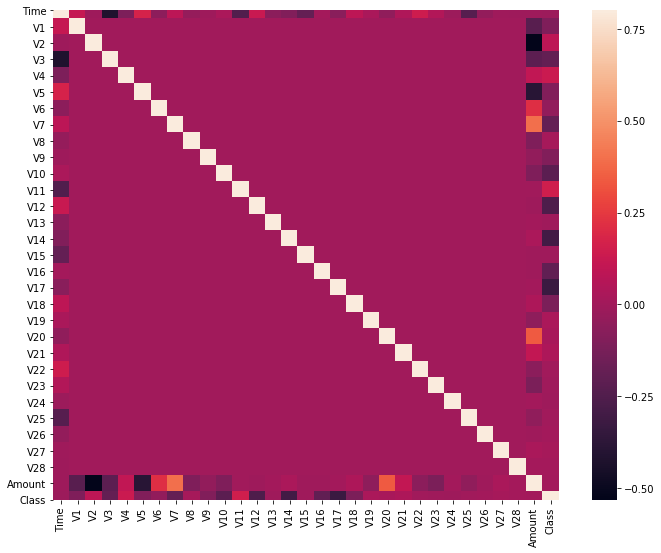

In [53]:
# Correlation matrix 
corrmat = df.corr() 
fig = plt.figure(figsize = (12, 9)) 
sns.heatmap(corrmat, vmax = .8, square = True) 
plt.show() 

### Training and Testing Data Bifurcation and choose the best classifire in our case f1 of random forst is the best so random forst is good.

In [59]:
# Building the Random Forest Classifier (RANDOM FOREST) 
from sklearn.ensemble import RandomForestClassifier 
# Building the Random Forest Classifier (RANDOM FOREST) , Logistic Regression , LinearSVC
clfs = [RandomForestClassifier(),LogisticRegression()]#n_estimators=500 for random forst
best_f1 = 0
best_clf = None
# dividing the X and the Y from the dataset
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=.2)
for clf in clfs:
    print(f"training clf {clf}")
    clf = Pipeline([('clf', clf)])
    clf.fit(x_train, y_train)
    f1 = f1_score(y_test, clf.predict(x_test), average='micro')
    print(f"clf {clf} has f1 score of {f1}")
    if f1 > best_f1:
        best_f1 = f1
        best_clf = clf
print(f"trained with best f1 of {best_f1} \n\n")

training clf RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators='warn',
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


F:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


clf Pipeline(memory=None,
         steps=[('clf',
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=10, n_jobs=None,
                                        oob_score=False, random_state=None,
                                        verbose=0, warm_start=False))],
         verbose=False) has f1 score of 0.9996488887328394
training clf LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_

F:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


clf Pipeline(memory=None,
         steps=[('clf',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='warn', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False) has f1 score of 0.9993153330290369
trained with best f1 of 0.9996488887328394 




### We found that random forest is better than logistic regression

### Building all kinds of evaluating parameters

In [64]:
# Evaluating the classifier 
# printing every score of the classifier 
# scoring in anything 
from sklearn.metrics import classification_report, accuracy_score  
from sklearn.metrics import precision_score, recall_score 
from sklearn.metrics import f1_score, matthews_corrcoef 
from sklearn.metrics import confusion_matrix 
  
n_outliers = len(fraud) 
n_errors = (best_clf.predict(x_test) != y_test).sum() 
print("The model used is Random Forest classifier") 
  
acc = accuracy_score(y_test, best_clf.predict(x_test)) 
print("The accuracy is {}".format(acc)) 
  
prec = precision_score(y_test, best_clf.predict(x_test)) 
print("The precision is {}".format(prec)) 
  
rec = recall_score(y_test, best_clf.predict(x_test)) 
print("The recall is {}".format(rec)) 
  
f1 = f1_score(y_test, best_clf.predict(x_test)) 
print("The F1-Score is {}".format(f1)) 
  
MCC = matthews_corrcoef(y_test, best_clf.predict(x_test)) 
print("The Matthews correlation coefficient is{}".format(MCC)) 

The model used is Random Forest classifier
The accuracy is 0.9996488887328394
The precision is 0.9375
The recall is 0.8333333333333334
The F1-Score is 0.8823529411764706
The Matthews correlation coefficient is0.8837125370168692


### Visulalizing the Confusion Matrix

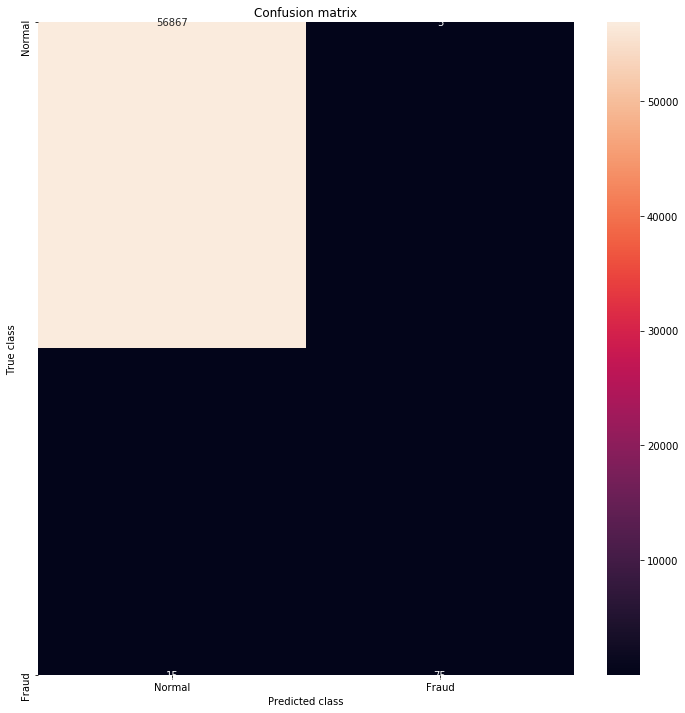

In [66]:
# printing the confusion matrix 
LABELS = ['Normal', 'Fraud'] 
conf_matrix = confusion_matrix(y_test, best_clf.predict(x_test)) 
plt.figure(figsize =(12, 12)) 
sns.heatmap(conf_matrix, xticklabels = LABELS,  
            yticklabels = LABELS, annot = True, fmt ="d"); 
plt.title("Confusion matrix") 
plt.ylabel('True class') 
plt.xlabel('Predicted class') 
plt.show() 